# VOC 데이터 처리 예제

## 준비하기

### Conda 환경 생성

```
conda create -n voc python=3.11
```

### PyDSPTools 설치

[Azure DevOps PyDSP 프로젝트](https://dev.azure.com/Seegene-SW/PyDSP)에 접근 권한이 있어야 합니다. Azure DevOps 프로젝트에 접근 권한이 없는 경우, [김형규 과장](mailto:hgkim2@seegene.com)에게 요청 부탁드립니다.

Azure DevOps Personal Access Token 생성

1. [Azure DevOps Personal Access Token](https://dev.azure.com/Seegene-SW/_usersSettings/tokens)에 접속합니다.
2. New Token 버튼을 클릭합니다.
3. Name에 토큰 이름을 입력합니다.
4. Organization에 Seegene-SW를 선택합니다.
5. Scopes에 Custom defined을 선택합니다.
6. Custom defined에 Packaging에 Read를 선택합니다.
7. Create 버튼을 클릭합니다.

다음과 같이 `~/.netrc` 파일 생성

```
machine pkgs.dev.azure.com
    login <Azure DevOps 사용자 이메일>
    password <Azure DevOps Personal Access Token>
```

설치하기

```
pip install --upgrade --index-url https://pkgs.dev.azure.com/Seegene-SW/PyDSP/_packaging/PyDSP/pypi/simple/ pydsp
pip install --upgrade --index-url https://pkgs.dev.azure.com/Seegene-SW/PyDSP/_packaging/PyDSP/pypi/simple/ pydsptools
```

## 분석하기

In [1]:
# Install Requirements

# !sudo apt-get install libc++-dev libc++abi-dev
# !pip install --index-url https://pkgs.dev.azure.com/Seegene-SW/PyDSP/_packaging/PyDSP/pypi/simple/ --upgrade "pydsp>=2.1.0a2" "pydsptools>=0.3.2"

In [2]:
import pathlib

import pandas as pd

Seegene Export 데이터를 다음과 같이 Parquet 파일로 변환

In [3]:
pathlib.Path(f"processed/example1").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"processed/example2").mkdir(parents=True, exist_ok=True)

In [4]:
!python -m pydsptools.biorad.parse -t cfx-xl -f parquet -o "processed/example1" "data/20. 체코_RP1/"

2024-01-05 19:24:27,342 - 357833 - INFO - Parse data/20. 체코_RP1/
2024-01-05 19:24:27,652 - 357833 - INFO - Convert to Arrow: 1. RP1 _2015-02-17 15-20-27_BR100181
2024-01-05 19:24:27,672 - 357833 - INFO - Write to processed/example1/1. RP1 _2015-02-17 15-20-27_BR100181.parquet


In [5]:
!python -m pydsptools.biorad.parse -t cfx-xl -f parquet -o "processed/example2" "data/11. SSI191220-001_스페인_RP1, RP2, RP3"

2024-01-05 19:24:28,408 - 357880 - INFO - Parse data/11. SSI191220-001_스페인_RP1, RP2, RP3/
2024-01-05 19:24:28,740 - 357880 - INFO - Convert to Arrow: 1. Para ALFONSO_Fallo software FAm VRS A - RP123 STARLET_2019-10-2811-20-16_B
2024-01-05 19:24:28,770 - 357880 - INFO - Write to processed/example2/1. Para ALFONSO_Fallo software FAm VRS A - RP123 STARLET_2019-10-2811-20-16_B.parquet


Processed Parquet 파일에 `pcr_system`, `consumable`, `temperature`, `experiment_name`, `plate_name` 컬럼 추가

In [6]:
TESTNAME = "example1"
PCR_SYSTEM = "CFX96"
CONSUMABLE = "8-strip"
EXPERIMENT_NAME = "20. 체코_RP1"
PLATE_NAME = "plate_data_001"
PROTOCOL = {4: "Low", 5: "High"}

paths = pathlib.Path(f"./processed/{TESTNAME}").glob("*.parquet")
for path in paths:
    name = path.name[:-8]
    df = pd.read_parquet(path)
    df["pcr_system"] = PCR_SYSTEM
    df["consumable"] = CONSUMABLE
    df["temperature"] = df.apply(lambda x: PROTOCOL[x["step"]], axis=1)
    df["experiment_name"] = EXPERIMENT_NAME
    df["plate_name"] = PLATE_NAME
    outdir = pathlib.Path(f"./computed/{TESTNAME}/pcr_results")
    if outdir.exists() is False:
        outdir.mkdir(parents=True)
    df.to_parquet(outdir / f"{name}.parquet")

In [7]:
TESTNAME = "example2"
PCR_SYSTEM = "CFX96"
CONSUMABLE = "8-strip"
EXPERIMENT_NAME = "11. SSI191220-001_스페인_RP1, RP2, RP3"
PLATE_NAME = "plate_data_001"
PROTOCOL = {4: "Low", 5: "High"}

paths = pathlib.Path(f"./processed/{TESTNAME}").glob("*.parquet")
for path in paths:
    name = path.name[:-8]
    df = pd.read_parquet(path)
    df["pcr_system"] = PCR_SYSTEM
    df["consumable"] = CONSUMABLE
    df["temperature"] = df.apply(lambda x: PROTOCOL[x["step"]], axis=1)
    df["experiment_name"] = EXPERIMENT_NAME
    df["plate_name"] = PLATE_NAME
    outdir = pathlib.Path(f"./computed/{TESTNAME}/pcr_results")
    if outdir.exists() is False:
        outdir.mkdir(parents=True)
    df.to_parquet(outdir / f"{name}.parquet")

DSP 실행

```
docker run -it --rm -v $(pwd):/code seegene/pydsp:2.1.0-alpha.1 python -m pydsp.run.worker multiple \
    -i /code/computed/example1/pcr_results \
    -c /code/config/yaml/PRJDS001/RP1/dsp1_orig.yml \
    -o /code/computed/example1/config__dsp1_orig
```

In [8]:
pathlib.Path(f"computed/example1/config__dsp1_orig/dsp").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"computed/example2/config__dsp1_orig/dsp").mkdir(parents=True, exist_ok=True)

In [9]:
!python -m pydsp.run.worker multiple \
    -i computed/example1/pcr_results \
    -c config/yaml/PRJDS001/RP1/dsp1_orig.yml \
    -o computed/example1/config__dsp1_orig

2024-01-05 19:24:29,596 - 357937 - INFO - Check entry /home/kmkim/pda/dsp-research-voc/computed/example1/pcr_results/1. RP1 _2015-02-17 15-20-27_BR100181.parquet
2024-01-05 19:24:29,638 - 357937 - INFO - Start 1 tasks
2024-01-05 19:24:30,020 - 357981 - INFO - Start file:///home/kmkim/pda/dsp-research-voc/computed/example1/pcr_results/1. RP1 _2015-02-17 15-20-27_BR100181.parquet
2024-01-05 19:24:30,392 - 357981 - INFO - Save computed/example1/config__dsp1_orig/dsp/1. RP1 _2015-02-17 15-20-27_BR100181.dsp.parquet
2024-01-05 19:24:30,406 - 357937 - INFO - All tasks done
2024-01-05 19:24:30,407 - 357981 - INFO - process shutting down
2024-01-05 19:24:30,414 - 357937 - INFO - process shutting down


In [10]:
!docker run -it --rm -v $(pwd):/code seegene/pydsp:2.1.0-alpha.1 python -m pydsp.run.worker multiple \
    -i /code/computed/example2/pcr_results \
    -c /code/config/yaml/PRJDS001/RP1/dsp1_orig.yml \
    -o /code/computed/example2/config__dsp1_orig

2024-01-05 10:24:31,561 - 1 - INFO - Check entry /code/computed/example2/pcr_results/1. Para ALFONSO_Fallo software FAm VRS A - RP123 STARLET_2019-10-2811-20-16_B.parquet
2024-01-05 10:24:31,637 - 1 - INFO - Start 1 tasks
2024-01-05 10:24:32,139 - 37 - INFO - Start file:///code/computed/example2/pcr_results/1. Para ALFONSO_Fallo software FAm VRS A - RP123 STARLET_2019-10-2811-20-16_B.parquet
2024-01-05 10:24:32,858 - 37 - INFO - Save /code/computed/example2/config__dsp1_orig/dsp/1. Para ALFONSO_Fallo software FAm VRS A - RP123 STARLET_2019-10-2811-20-16_B.dsp.parquet
2024-01-05 10:24:32,880 - 1 - INFO - All tasks done
2024-01-05 10:24:32,881 - 37 - INFO - process shutting down
2024-01-05 10:24:32,891 - 1 - INFO - process shutting down


분석

In [11]:
import pydsptools.plot as dspplt

In [20]:
df = pd.read_parquet('computed/example1/config__dsp1_orig/dsp/1. RP1 _2015-02-17 15-20-27_BR100181.dsp.parquet')

In [21]:
df.head()

,name,steps,pcr_system,consumable,welltype,well,channel,temperature,original_rfu,has_melt,...,postproc_ct,has_ctalk,ctalk_resultwell,ctalk_dataprocnum,ctalk_ct,final_resultwell,final_dataprocnum,final_ct,experiment_name,plate_name
0,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,Sample,A01,FAM,Low,"[21184.8276041249, 21106.1756240489, 21011.761...",0,...,-1.000000,0,0,0,0,1.0,2.0,-1.000000,20. 체코_RP1,plate_data_001
1,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,Sample,A01,FAM,High,"[21441.315877728, 21429.1163752568, 21364.8813...",0,...,37.145472,0,0,0,0,0.0,0.0,37.145472,20. 체코_RP1,plate_data_001
2,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,Sample,A01,HEX,Low,"[4844.45371876817, 4837.80217186882, 4830.3241...",0,...,-1.000000,0,0,0,0,1.0,1.0,-1.000000,20. 체코_RP1,plate_data_001
3,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,Sample,A01,HEX,High,"[5254.91360159913, 5245.42056518688, 5238.2580...",0,...,-1.000000,0,0,0,0,1.0,1.0,-1.000000,20. 체코_RP1,plate_data_001
4,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,Sample,A01,Cal Red 610,Low,"[6813.1806841619, 6790.42379588041, 6771.24123...",0,...,-1.000000,0,0,0,0,1.0,1.0,-1.000000,20. 체코_RP1,plate_data_001


In [23]:
df.columns

Index(['name', 'steps', 'pcr_system', 'consumable', 'welltype', 'well',
       'channel', 'temperature', 'original_rfu', 'has_melt', 'melt',
       'melt_idx', 'setval_ispc', 'setval_used_temp', 'setval_thrd',
       'preproc_resultwell', 'preproc_dataprocnum', 'preproc_rfu',
       'preproc_endrfu', 'analysis_resultwell', 'analysis_dataprocnum',
       'analysis_lsr_val', 'analysis_rd_diff', 'analysis_ivd_cdd_output',
       'analysis_cff', 'analysis_scd_fit', 'analysis_r_p2', 'analysis_efc',
       'analysis_absd_orig', 'analysis_absd', 'analysis_f', 'analysis_f_new',
       'analysis_sht', 'analysis_sht2', 'analysis_param', 'analysis_param_new',
       'analysis_r2', 'analysis_endrfu', 'analysis_df', 'analysis_ct',
       'postproc_resultwell', 'postproc_dataprocnum', 'postproc_ct',
       'has_ctalk', 'ctalk_resultwell', 'ctalk_dataprocnum', 'ctalk_ct',
       'final_resultwell', 'final_dataprocnum', 'final_ct', 'experiment_name',
       'plate_name'],
      dtype='object')

In [30]:
df[df['setval_ispc']==1]

,name,steps,pcr_system,consumable,welltype,well,channel,temperature,original_rfu,has_melt,...,postproc_ct,has_ctalk,ctalk_resultwell,ctalk_dataprocnum,ctalk_ct,final_resultwell,final_dataprocnum,final_ct,experiment_name,plate_name
88,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,FAM,Low,"[18808.1245409867, 18683.9979336548, 18544.325...",0,...,20.262437,0,0,0,0,0.0,-3.0,20.262437,20. 체코_RP1,plate_data_001
89,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,FAM,High,"[18587.3610077071, 18520.2563558091, 18451.970...",0,...,16.346155,0,0,0,0,-2.0,-2.0,16.346155,20. 체코_RP1,plate_data_001
90,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,HEX,Low,"[4524.2746308553, 4508.17017079507, 4487.51104...",0,...,22.772974,0,0,0,0,0.0,0.0,22.772974,20. 체코_RP1,plate_data_001
91,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,HEX,High,"[4871.65657895929, 4854.66747020544, 4847.2537...",0,...,21.494555,0,0,0,0,-2.0,-2.0,21.494555,20. 체코_RP1,plate_data_001
92,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,Cal Red 610,Low,"[6333.01781477878, 6290.4102828995, 6252.23282...",0,...,21.303390,0,0,0,0,0.0,-3.0,21.303390,20. 체코_RP1,plate_data_001
93,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,Cal Red 610,High,"[6964.8978994012, 6930.26388533646, 6898.99672...",0,...,20.414985,0,0,0,0,0.0,-3.0,20.414985,20. 체코_RP1,plate_data_001
94,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,Quasar 670,Low,"[5822.87197490964, 5795.40067264352, 5773.9990...",0,...,19.965064,0,0,0,0,0.0,0.0,19.965064,20. 체코_RP1,plate_data_001
95,1. RP1 _2015-02-17 15-20-27_BR100181,"[4, 5]",None,8-strip,PC,D03,Quasar 670,High,"[5200.45196654786, 5187.01395067171, 5174.0312...",0,...,21.292709,0,0,0,0,-2.0,-2.0,21.292709,20. 체코_RP1,plate_data_001


In [14]:
p = dspplt.DspResultLegacyPlot(df)

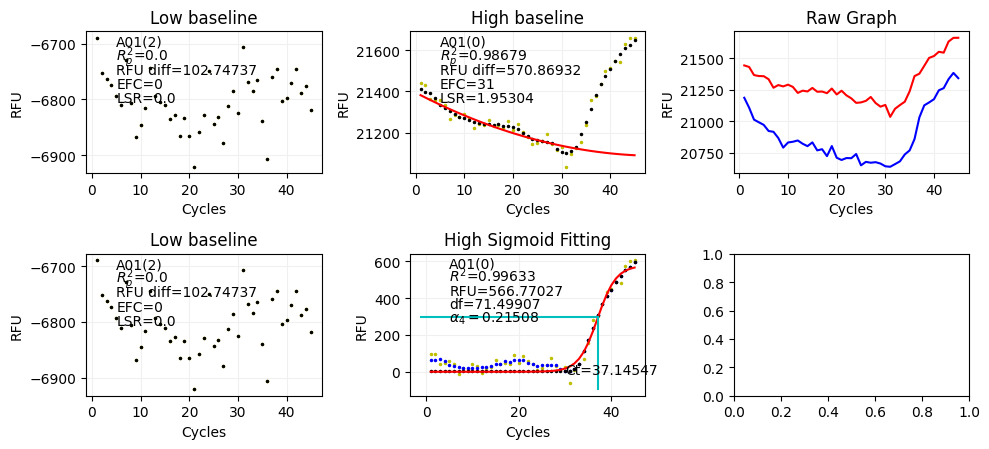

In [15]:
p.plot(well="A01", channel="FAM")

In [16]:
df = pd.read_parquet('computed/example2/config__dsp1_orig/dsp/1. Para ALFONSO_Fallo software FAm VRS A - RP123 STARLET_2019-10-2811-20-16_B.dsp.parquet')

In [17]:
df.head()

,name,steps,pcr_system,consumable,welltype,well,channel,temperature,original_rfu,has_melt,...,postproc_ct,has_ctalk,ctalk_resultwell,ctalk_dataprocnum,ctalk_ct,final_resultwell,final_dataprocnum,final_ct,experiment_name,plate_name
0,1. Para ALFONSO_Fallo software FAm VRS A - RP1...,"[4, 5]",None,8-strip,Sample,A01,FAM,Low,"[17281.0731448633, 17126.0061711674, 17063.673...",0,...,23.590441,0,0,0,0,0.0,0.0,23.590441,"11. SSI191220-001_스페인_RP1, RP2, RP3",plate_data_001
1,1. Para ALFONSO_Fallo software FAm VRS A - RP1...,"[4, 5]",None,8-strip,Sample,A01,FAM,High,"[17986.1333988325, 17914.3453069006, 17872.985...",0,...,-1.000000,0,0,0,0,1.0,2.0,-1.000000,"11. SSI191220-001_스페인_RP1, RP2, RP3",plate_data_001
2,1. Para ALFONSO_Fallo software FAm VRS A - RP1...,"[4, 5]",None,8-strip,Sample,A01,HEX,Low,"[5172.05750233063, 5142.73324864169, 5127.9351...",0,...,-1.000000,0,0,0,0,1.0,1.0,-1.000000,"11. SSI191220-001_스페인_RP1, RP2, RP3",plate_data_001
3,1. Para ALFONSO_Fallo software FAm VRS A - RP1...,"[4, 5]",None,8-strip,Sample,A01,HEX,High,"[5748.51204992537, 5737.52600219799, 5714.3737...",0,...,-1.000000,0,0,0,0,1.0,1.0,-1.000000,"11. SSI191220-001_스페인_RP1, RP2, RP3",plate_data_001
4,1. Para ALFONSO_Fallo software FAm VRS A - RP1...,"[4, 5]",None,8-strip,Sample,A01,Cal Red 610,Low,"[8420.8513238985, 8349.81479308575, 8324.19137...",0,...,-1.000000,0,0,0,0,4.0,8.0,-1.000000,"11. SSI191220-001_스페인_RP1, RP2, RP3",plate_data_001


In [18]:
p = dspplt.DspResultLegacyPlot(df)

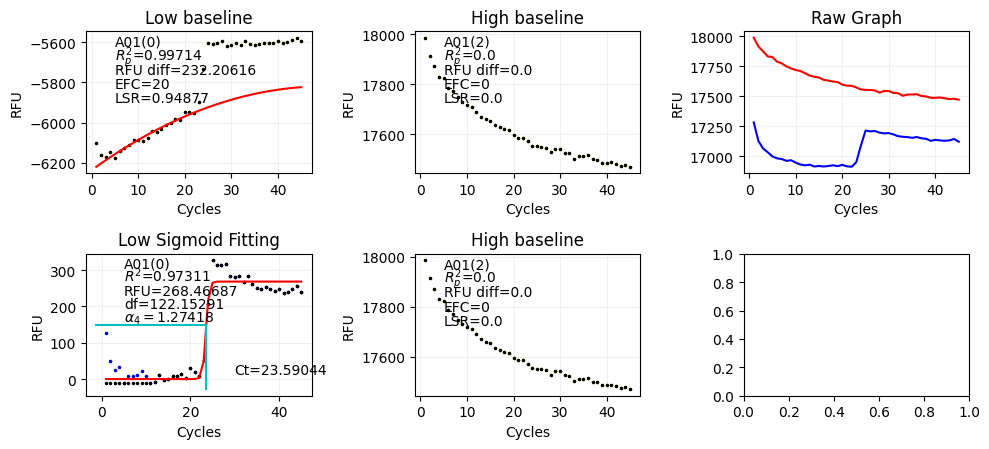

In [19]:
p.plot(well="A01", channel="FAM")